# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Step 1 : Data Preparation

Portfolio

This dataset is pretty straightforward, we have a list of 10 offers with the specific informations.

In [3]:
rows, cols = portfolio.shape
print(f'There are {rows} rows and {cols} columns.\n')
portfolio

There are 10 rows and 6 columns.



,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


# Profile

This dataset has information about customers.

Data preparation:

 - Transform the _became_memberon feature into a date feature.
 - Analyse the missing features and eventually apply a transformation.

In [4]:
rows, cols = profile.shape
print(f'There are {rows} rows and {cols} columns.\n')
profile.head()

There are 17000 rows and 5 columns.



,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
cust = len(profile['id'].unique().tolist())
print(f'On {len(profile)} records we have {cust} customers')

On 17000 records we have 17000 customers


It seems that there are no duplicates.

In [6]:
# To transform the feature, we create a new column
profile['member_on'] = pd.to_datetime(profile['became_member_on'].astype(str)).dt.date
profile.drop('became_member_on', 1, inplace=True)

There are some missing values in gender and income: let's dive in this subset.

In [7]:
profile.loc[profile['gender'].isnull()].describe()

,age,income
count,2175.0,0.0
mean,118.0,NaN
std,0.0,NaN
min,118.0,NaN
25%,118.0,NaN
50%,118.0,NaN
75%,118.0,NaN
max,118.0,NaN


It seems like income is always null and age is always 118. Since we basically have no info on these profiles, we can safely drop them.

In [8]:
profile = profile.loc[profile['gender'].isnull() == False]

rows, cols = profile.shape
print(f'After data preparation, we have {rows} rows and {cols} columns.\n')

After data preparation, we have 14825 rows and 5 columns.



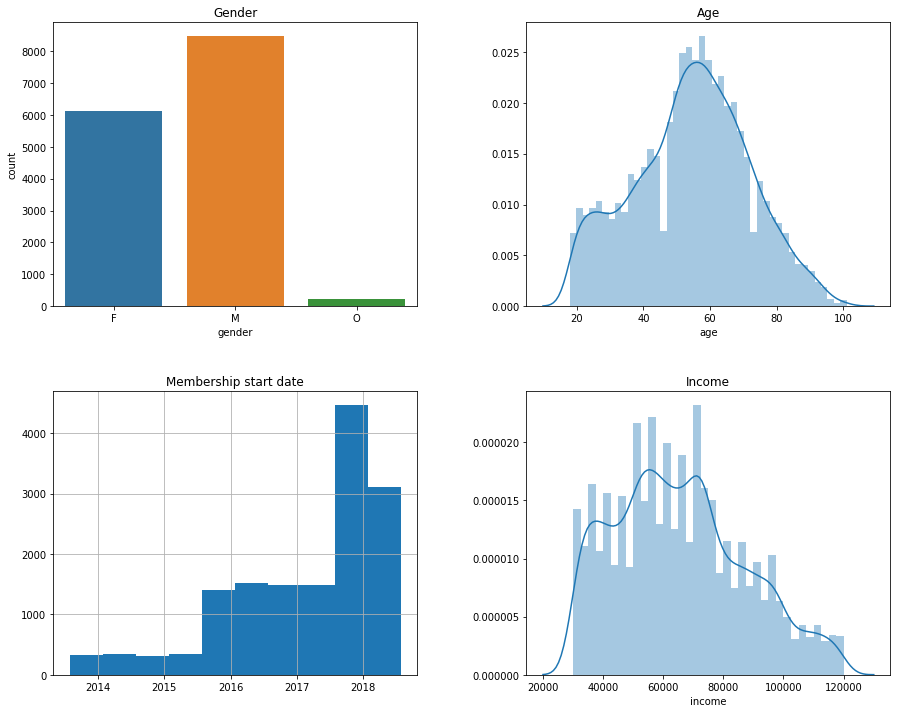


Membership start dates range from 2013-07-29 to 2018-07-26.



In [9]:
plt.subplots(2, 2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(221)
plt.title('Gender')
sns.countplot(x='gender', data=profile)

plt.subplot(222)
plt.title('Age')
sns.distplot(profile['age'])

plt.subplot(223)
plt.title('Membership start date')
profile['member_on'].hist()

plt.subplot(224)
plt.title('Income')
sns.distplot(profile['income'])

plt.show()


print('\nMembership start dates range from {} to {}.\n'.format(
    profile['member_on'].min().strftime('%Y-%m-%d'), profile['member_on'].max().strftime('%Y-%m-%d')
))

Some considerations:

    - there is a third gender O, with very few records
    - age has quite a normal distribution, while income has continuous spikes and has an irregular distribution
    - the customers are quite new members, since the memberships are concentrated from the last part of 2017 onwards


# Transcript

This dataframe contains the list of all actions on offers and transactions, with the relative information about money and time.

Data preparation:

    - Analyse the value feature and extract the information
    - Reconstruct the customer journey, from receiving the offer to the (eventual) transaction

In [10]:
rows, cols = transcript.shape
print(f'There are {rows} rows and {cols} columns.\n')
transcript.head(10)

There are 306534 rows and 4 columns.



,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [11]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [12]:
keys = transcript['value'].apply(lambda x: str(list(x.keys())))

pd.crosstab(keys, transcript['event'])

event,offer completed,offer received,offer viewed,transaction
value,,,,
['amount'],0,0,0,138953
['offer id'],0,76277,57725,0
"['offer_id', 'reward']",33579,0,0,0


The value could be:

    - offer_id for an offer received or viewed
    - reward plus offer_id for an offer completed
    - amount for a transaction
We should create columns for each of these values, dropping the original value column.

In [13]:
for k in ['reward', 'amount']:
    transcript[k] = transcript['value'].apply(lambda x: x[k] if k in x else None)
    
transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else (x['offer id'] if 'offer id' in x else None))
transcript.drop('value', 1, inplace=True)

In [14]:
transcript['time'].describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

The time feature ranges from 0 to 714 (29.75 days).

Let's take a look at what the history of a single customer: how many record has a customer?

In [15]:
cust_list = transcript.groupby('person')['time'].count()
cust_list.sort_values(ascending=False).head(3)

person
94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
79d9d4f86aca4bed9290350fb43817c2    48
Name: time, dtype: int64

The first customer has 51 records: let's take a look.

In [16]:
transcript.loc[transcript['person'] == cust_list.index[0]].sort_values('time')

,event,person,time,reward,amount,offer_id
55972,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
89291,transaction,0009655768c64bdeb2e877511632db8f,228,NaN,22.16,None
113605,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed
153401,offer received,0009655768c64bdeb2e877511632db8f,408,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
168412,transaction,0009655768c64bdeb2e877511632db8f,414,NaN,8.57,None
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,5.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
204340,offer received,0009655768c64bdeb2e877511632db8f,504,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4


It seems that for each offer completed there is a relative transaction with the same time. To verify this, we merge the to subsets.

In [17]:
tmp = pd.merge(transcript.loc[transcript['event'] == 'offer completed'],
               transcript.loc[transcript['event'] == 'transaction', ['person', 'event', 'time']],
               on=['person', 'time'])

print('There are {} offer completed.'.format(sum(transcript['event'] == 'offer completed')))
print('There are {} matches.'.format(tmp.shape[0]))

There are 33579 offer completed.
There are 33579 matches.


What's the relationship between offer received and viewed?

In [18]:
tmp = pd.merge(transcript.loc[transcript['event'] == 'offer viewed'].reset_index(),
               transcript.loc[transcript['event'] == 'offer received', ['person', 'time', 'offer_id']],
               on=['person', 'offer_id'])

print('There are {} offer viewed.'.format(sum(transcript['event'] == 'offer viewed')))
print('There are {} matches.'.format(len(tmp['index'].unique())))

There are 57725 offer viewed.
There are 57725 matches.


For each viewed offer there is a record with the relative received offer.

Finally, there's no clear relationship between offer viewed and completed: an offer can be viewed but not completed, and vice-versa (a customer completes an offer without knowing).

# Recreating the customer's journey

To better analyse the completion of the offers, we create a new dataframe recreating the entire funnel of customer's conversion:

    - At first, we join the offer received with the eventual view by the customer
    - Then, we follow the same approach to add information about conversion (offer completed)
    - Finally, we add the transactions. If there's a relative offer completed, we join the information to the row; if not, we add a new row.

In [20]:
#At first, let's join togheter the received offer with the relative (eventual) view
views = pd.merge(transcript.loc[transcript['event'] == 'offer received', ['person', 'offer_id', 'time']],
                 transcript.loc[transcript['event'] == 'offer viewed', ['person', 'offer_id', 'time']],
                 on=['person', 'offer_id'], how='left', suffixes=['_received', '_viewed'])

# We have to be sure to take the reception BEFORE the view (or when there's no view)
views = views.loc[(views['time_viewed'] >= views['time_received']) | (views['time_viewed'].isnull())]

# Then we take the NEAREST reception before the view
# We concatenate with the "missing view" dataframe portion, since aggregation results in a drop of these records
views = pd.concat((views.groupby(['person', 'offer_id', 'time_viewed']).agg({'time_received': 'max'}).reset_index(),
                  views.loc[views['time_viewed'].isnull()]),
                  axis=0, sort=True)

views.head()

,offer_id,person,time_received,time_viewed
0,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,336,372.0
1,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,168,192.0
2,f19421c1d4aa40978ebb69ca19b0e20d,0009655768c64bdeb2e877511632db8f,408,456.0
3,fafdcd668e3743c1bb461111dcafc2a4,0009655768c64bdeb2e877511632db8f,504,540.0
4,f19421c1d4aa40978ebb69ca19b0e20d,00116118485d4dfda04fdbaba9a87b5c,168,216.0


In [21]:
# Same reasoning joining the info about offer completion
comp = pd.merge(views,
                transcript.loc[transcript['event'] == 'offer completed', ['person', 'offer_id', 'time', 'reward']],
                on=['person', 'offer_id'], how='left').rename(columns={'time': 'time_completed'})

# When the completion time is AFTER the view time, we force the value to null
comp.loc[(comp['time_viewed'].isnull()) | (comp['time_viewed'] > comp['time_completed']), ['time_completed', 'reward']] = (np.nan, np.nan)
comp.drop_duplicates(inplace=True)

comp = pd.concat(
    (comp.groupby(['person', 'offer_id', 'time_completed', 'reward']).agg({'time_viewed': 'max', 'time_received': 'max'}).reset_index(),
     comp.loc[comp['time_completed'].isnull()]),
    axis=0, sort=True
)

comp.head()

,offer_id,person,reward,time_completed,time_received,time_viewed
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0011e0d4e6b944f998e987f904e8c1e5,5.0,576.0,408,432.0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,0011e0d4e6b944f998e987f904e8c1e5,3.0,252.0,168,186.0
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,0011e0d4e6b944f998e987f904e8c1e5,5.0,576.0,504,516.0
3,4d5c57ea9a6940dd891ad53e9dbe8da0,0020c2b971eb4e9188eac86d93036a77,10.0,510.0,408,426.0
4,fafdcd668e3743c1bb461111dcafc2a4,0020c2b971eb4e9188eac86d93036a77,2.0,54.0,0,12.0


In [22]:
# Now we join the information about the relative transaction
journey = pd.merge(comp,
                   transcript.loc[transcript['event'] == 'transaction', ['person', 'time', 'amount']],
                   left_on=['person', 'time_completed'], right_on=['person', 'time'], how='outer').rename(columns={'time': 'time_transaction'})

# Create a reference time - received for offer, transaction otherwise
journey['time'] = journey['time_received']
journey.loc[journey['time'].isnull(), 'time'] = journey['time_transaction']

# If an offer is completed twice, we have some duplicates: we have to remove them
journey.sort_values(['person', 'offer_id', 'time', 'time_completed'], inplace=True)
journey = journey.drop_duplicates(['person', 'offer_id', 'time'])

journey = journey[['person', 'offer_id', 'time', 'time_received', 'time_viewed', 'time_completed', 'time_transaction', 'amount', 'reward']]

rows, cols = journey.shape
print(f'There are {rows} rows and {cols} columns.\n')
journey.head()

There are 188234 rows and 9 columns.



,person,offer_id,time,time_received,time_viewed,time_completed,time_transaction,amount,reward
24618,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,576.0,NaN,NaN,NaN,NaN,NaN
24614,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,336.0,372.0,NaN,NaN,NaN,NaN
24615,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,168.0,192.0,NaN,NaN,NaN,NaN
24616,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,408.0,456.0,NaN,NaN,NaN,NaN
24617,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.0,504.0,540.0,NaN,NaN,NaN,NaN


# Join Data

Now we can join the 3 entities into one single dataset to analyse.

In [23]:
# Join offer info
tmp = pd.merge(journey,
               portfolio.rename(columns={'reward': 'pot_reward', 'id': 'offer_id'}),
               on='offer_id', how='left')

tmp.head()

,person,offer_id,time,time_received,time_viewed,time_completed,time_transaction,amount,reward,channels,difficulty,duration,offer_type,pot_reward
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,576.0,NaN,NaN,NaN,NaN,NaN,"[web, email, mobile]",10.0,7.0,discount,2.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,336.0,372.0,NaN,NaN,NaN,NaN,"[web, email, mobile]",0.0,4.0,informational,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,168.0,192.0,NaN,NaN,NaN,NaN,"[email, mobile, social]",0.0,3.0,informational,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,408.0,456.0,NaN,NaN,NaN,NaN,"[web, email, mobile, social]",5.0,5.0,bogo,5.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.0,504.0,540.0,NaN,NaN,NaN,NaN,"[web, email, mobile, social]",10.0,10.0,discount,2.0


In [24]:
# Join person info
# We will lose some records since we dropped some profiles with no informations

df = pd.merge(tmp,
              profile.rename(columns={'id': 'person'}),
              how='inner', on='person')

# To better visualize the journey, let's order by the offer received time / transaction time
df.sort_values(['person', 'time', 'offer_id'], inplace=True)

# For transactions we put a specific "offer type"
df['offer_type'].fillna('transaction', inplace=True)

rows, cols = df.shape
print(f'There are {rows} rows and {cols} columns.\n')
df.head()

There are 164838 rows and 18 columns.



,person,offer_id,time,time_received,time_viewed,time_completed,time_transaction,amount,reward,channels,difficulty,duration,offer_type,pot_reward,age,gender,income,member_on
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,168.0,192.0,NaN,NaN,NaN,NaN,"[email, mobile, social]",0.0,3.0,informational,0.0,33,M,72000.0,2017-04-21
5,0009655768c64bdeb2e877511632db8f,NaN,228.0,NaN,NaN,NaN,228.0,22.16,NaN,NaN,NaN,NaN,transaction,NaN,33,M,72000.0,2017-04-21
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,336.0,372.0,NaN,NaN,NaN,NaN,"[web, email, mobile]",0.0,4.0,informational,0.0,33,M,72000.0,2017-04-21
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,408.0,456.0,NaN,NaN,NaN,NaN,"[web, email, mobile, social]",5.0,5.0,bogo,5.0,33,M,72000.0,2017-04-21
6,0009655768c64bdeb2e877511632db8f,NaN,414.0,NaN,NaN,NaN,414.0,8.57,NaN,NaN,NaN,NaN,transaction,NaN,33,M,72000.0,2017-04-21


In [25]:
# Write output
df.to_csv('./data/journey.csv', index=False)